# Phase 1: Data Preparation

In [38]:
import os
import shutil
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [39]:
DATASET_PATH = '../Data/asl_alphabet_train/'

words = os.listdir(DATASET_PATH)

print("📂 Classes:", words)
print("🔢 Total Classes:", len(words))

📂 Classes: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
🔢 Total Classes: 28


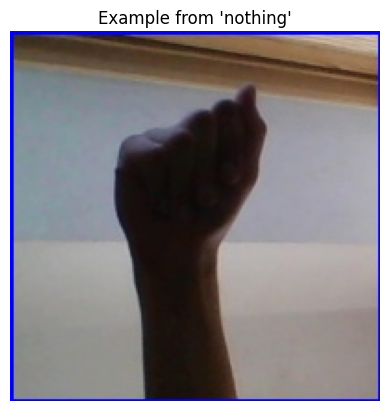

In [40]:
img_path = '../Data/asl_alphabet_train/A/A1.jpg'

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title("Example from 'nothing'")
plt.show()

In [ ]:
folder_path = os.path.join(DATASET_PATH, "nothing")

img_name = os.listdir(folder_path)[0]
img_path = os.path.join(folder_path, img_name)

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title("Example from 'nothing'")
plt.show()


In [42]:
# remove unwanted folder
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  
    print("Done")
else:
    print("Folder not found")


Folder not found


In [43]:
words = os.listdir(DATASET_PATH)

print("📂 Classes:", words)
print("🔢 Total Classes:", len(words))

📂 Classes: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
🔢 Total Classes: 28


In [44]:
label_map = {word: idx for idx, word in enumerate(words)}
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'del': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'J': 10,
 'K': 11,
 'L': 12,
 'M': 13,
 'N': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'space': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

In [45]:
# save label_map as json file
with open("sign_to_prediction_index_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("✅ sign_to_prediction_index_map.json saved")

✅ sign_to_prediction_index_map.json saved


In [46]:
# collect file paths + labels 
paths = []
labels = []

for cname in words:
    folder = os.path.join(DATASET_PATH, cname)
    for fname in os.listdir(folder):
        paths.append(os.path.join(folder, fname))
        labels.append(label_map[cname])

print("Total images found:", len(paths))


Total images found: 84000


In [47]:
paths[0]

'../Data/asl_alphabet_train/A\\A1.jpg'

In [48]:
labels[0]

0

In [49]:
# stratified Train/Val split
from sklearn.model_selection import train_test_split
from collections import Counter

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train images:", len(train_paths))
print("Val images:", len(val_paths))
print("Train class counts:", Counter(train_labels))
print("Val class counts:", Counter(val_labels))

Train images: 67200
Val images: 16800
Train class counts: Counter({6: 2400, 17: 2400, 20: 2400, 16: 2400, 9: 2400, 3: 2400, 27: 2400, 5: 2400, 18: 2400, 19: 2400, 7: 2400, 13: 2400, 15: 2400, 26: 2400, 23: 2400, 21: 2400, 10: 2400, 11: 2400, 8: 2400, 24: 2400, 22: 2400, 0: 2400, 12: 2400, 4: 2400, 1: 2400, 2: 2400, 14: 2400, 25: 2400})
Val class counts: Counter({8: 600, 0: 600, 22: 600, 3: 600, 21: 600, 2: 600, 16: 600, 12: 600, 7: 600, 17: 600, 27: 600, 18: 600, 6: 600, 24: 600, 14: 600, 11: 600, 15: 600, 4: 600, 13: 600, 5: 600, 1: 600, 19: 600, 26: 600, 20: 600, 23: 600, 10: 600, 25: 600, 9: 600})


In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.utils as vutils

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [52]:
# Dataset class ======
class ASLDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')   # keep RGB
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [ ]:
img_size = 100

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [54]:
# create datasets and dataloaders 
batch_size = 32

train_ds = ASLDataset(train_paths, train_labels, transform=train_transform)
val_ds = ASLDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Train batches: 2100 Val batches: 525
